# Master's Thesis Experiments Report

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scripts.utils import load_latency_data, load_frame_size_data, clean_latency_data

In [2]:
# constants
FIG_DIR = './figures/{}'

## 1.   Pipeline Latency
The data was replayed at 8 Mbps.
For each frame f, we measure the timedelta between the last emitted LiDAR data packet and
the last incoming Palicus data packet containing data associated with f.
We exclude the first and the last frame to ensure that we only consider the latency of full frames.

In [3]:
fig_dir = FIG_DIR.format('latency')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [4]:
# Load the data
df_conversion = load_latency_data(pipeline='conversion')
df_roi = load_latency_data(pipeline='roi')
df_dm1 = load_latency_data(pipeline='dm1')
df_dm2 = load_latency_data(pipeline='dm2')
df_bev = load_latency_data(pipeline='bev')
df_max = load_latency_data(pipeline='max')

In [5]:
# tabular representation
l = 'latency [ms]'

results = [['min', df_conversion.min()[l], df_roi.min()[l], df_dm1.min()[l], df_dm2.min()[l], df_bev.min()[l],
            df_max.min()[l]],
           ['mean', df_conversion.mean()[l], df_roi.mean()[l], df_dm1.mean()[l], df_dm2.mean()[l], df_bev.mean()[l],
            df_max.mean()[l]],
           ['median', df_conversion.median()[l], df_roi.median()[l], df_dm1.median()[l], df_dm2.median()[l],
            df_bev.median()[l], df_max.median()[l]],
           ['max', df_conversion.max()[l], df_roi.max()[l], df_dm1.max()[l], df_dm2.max()[l], df_bev.max()[l],
            df_max.max()[l]]
           ]

df_latency_results = pd.DataFrame(results, columns=['', 'CONV', 'RoI', 'DM (1)', 'DM (2)', 'BEV', 'MAX'])
print(df_latency_results)


              CONV       RoI    DM (1)    DM (2)        BEV        MAX
0     min  0.19040  0.186200  0.185200  0.193200   0.294200   0.297800
1    mean  0.38236  0.387328  0.388334  0.389076  46.049722  46.049746
2  median  0.30000  0.299800  0.300800  0.301400  47.708600  47.709400
3     max  1.56920  1.606200  1.563400  1.576000  47.823800  47.828400


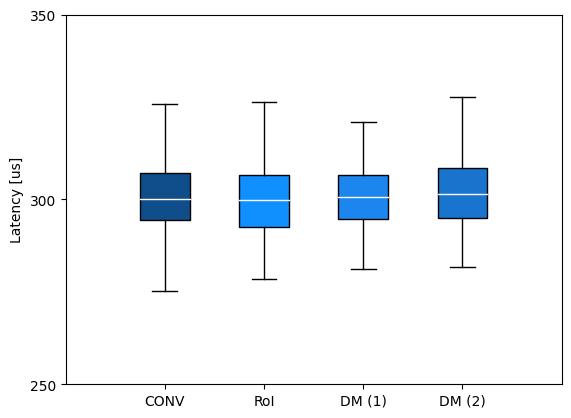

In [6]:
# computation time: conversion vs. RoI vs. DepthMap
df_conversion['CONV'] = df_conversion['latency [ms]'] * 1000
df_roi['RoI'] = df_roi['latency [ms]'] * 1000
df_dm1['DM (1)'] = df_dm1['latency [ms]'] * 1000
df_dm2['DM (2)'] = df_dm2['latency [ms]'] * 1000

fig, ax = plt.subplots()
ax.boxplot(df_conversion['CONV'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['CONV'], 
           boxprops={'facecolor': '#104E8B'}, medianprops={'color': 'white'})
ax.boxplot(df_roi['RoI'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['RoI'], 
           boxprops={'facecolor': '#1090FF'}, medianprops={'color': 'white'})
ax.boxplot(df_dm1['DM (1)'].to_numpy(), positions=[6], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['DM (1)'], 
           boxprops={'facecolor': '#1C86EE'}, medianprops={'color': 'white'})
ax.boxplot(df_dm2['DM (2)'].to_numpy(), positions=[8], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['DM (2)'], 
           boxprops={'facecolor': '#1874CD'}, medianprops={'color': 'white'})
ax.set(xlim=(0, 10))
ax.set(ylim=(250, 350), yticks=[250 + i * 50 for i in range(3)], ylabel='Latency [us]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'conv_roi_dm.png'))

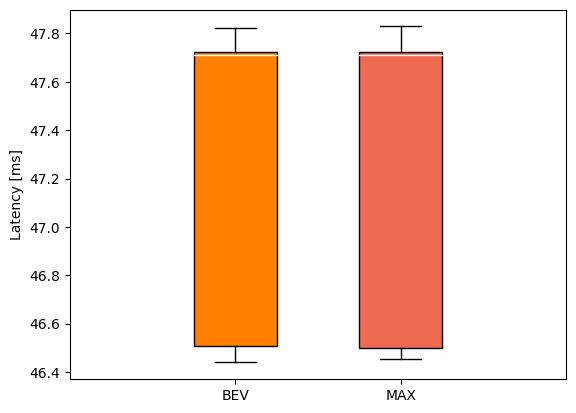

In [7]:
# computation time: BEV vs. MAX
fig, ax = plt.subplots()
ax.boxplot(df_bev['latency [ms]'].to_numpy(), positions=[2], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['BEV'], 
           boxprops={'facecolor': '#FF7F00'}, medianprops={'color': 'white'})
ax.boxplot(df_max['latency [ms]'].to_numpy(), positions=[4], widths=[1],
           patch_artist=True, showmeans=False, showfliers=False, labels=['MAX'], 
           boxprops={'facecolor': '#EE6A50'}, medianprops={'color': 'white'})
ax.set(xlim=(0, 6))
ax.set(ylabel='Latency [ms]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'bev_max.png'))

### Latency Impact of PEs

In [8]:
f = 'diff'
BINS = [-160, -120, -80, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 80,
        120, 160, 200, 260]

# FPE - impact in [us]
df_compare_fpe = pd.concat([df_conversion.loc[:, 'CONV'], df_roi.loc[:, 'RoI']], axis=1)
df_compare_fpe[f] = df_compare_fpe['RoI'] - df_compare_fpe['CONV']

res_table = [['FPE [us]', df_compare_fpe.min()[f], df_compare_fpe.mean()[f], df_compare_fpe.median()[f], df_compare_fpe.max()[f]]]

df_compare_fpe = clean_latency_data(df_compare_fpe, col=f, factor=2)

fpe_counts, fpe_bins = np.histogram(df_compare_fpe[f].to_numpy(), bins=BINS)
fpe_counts = fpe_counts / np.sum(fpe_counts) * 100

In [9]:
# ArPE - impact in [us]
df_compare_1 = pd.concat([df_roi.loc[:, 'RoI'],
                          df_dm1.loc[:, 'DM (1)']], axis=1)
df_compare_1['diff'] = df_compare_1['DM (1)'] - df_compare_1['RoI']
df_compare_1 = df_compare_1.loc[:, 'diff']

df_compare_2 = pd.concat([df_dm1.loc[:, 'DM (1)'],
                          df_dm2.loc[:, 'DM (2)']], axis=1)
df_compare_2['diff'] = df_compare_2['DM (2)'] - df_compare_2['DM (1)']
df_compare_2 = df_compare_2.loc[:, 'diff']

df_compare_arpe = pd.DataFrame(pd.concat([df_compare_1, df_compare_2.rename('diff')], axis=0))

res_table.append(['ArPE [us]', df_compare_arpe.min()[f], df_compare_arpe.mean()[f], df_compare_arpe.median()[f], df_compare_arpe.max()[f]])

df_compare_arpe = clean_latency_data(df_compare_arpe, col=f, factor=2)
arpe_counts, arpe_bins = np.histogram(df_compare_arpe[f].to_numpy(), bins=BINS)
arpe_counts = arpe_counts / np.sum(arpe_counts) * 100




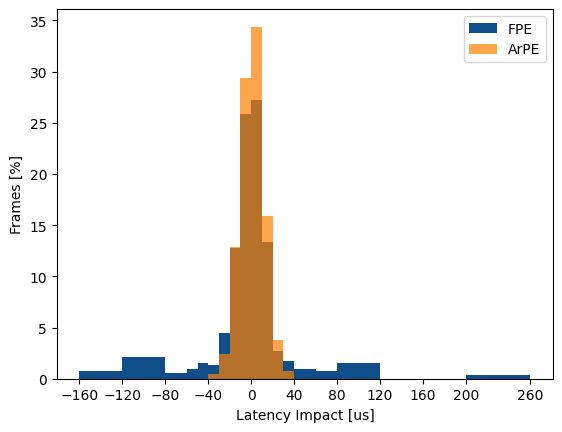

In [10]:
# visualize
fig, ax = plt.subplots()
ax.hist(BINS[:-1], BINS, weights=fpe_counts, label='FPE', color='#104E8B')
ax.hist(BINS[:-1], BINS, weights=arpe_counts, label='ArPE', color='#FF7F00', alpha=0.7)
ax.legend()
ax.set(xlabel='Latency Impact [us]', 
       xticks=[-160, -120, -80, -40, 0, 40, 80, 120, 160, 200, 260])
ax.set(ylabel='Frames [%]')
plt.show()
fig.savefig(os.path.join(fig_dir, 'fpe_arpe_impact.png'))

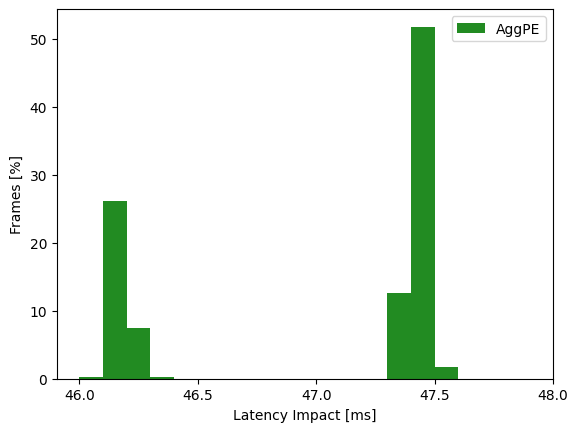

In [11]:
# AggPE - [ms]
df_compare_aggpe = pd.concat([df_dm2.loc[:, 'latency [ms]'].rename('DM'),
                              df_bev.loc[:, 'latency [ms]'].rename('BEV')], axis=1)
df_compare_aggpe['diff'] = df_compare_aggpe['BEV'] - df_compare_aggpe['DM']
res_table.append(['AggPE [ms]', df_compare_aggpe.min()[f], df_compare_aggpe.mean()[f], df_compare_aggpe.median()[f], df_compare_aggpe.max()[f]])

df_compare_aggpe = clean_latency_data(df_compare_aggpe, col=f, factor=2)

AGG_BINS = [46 + i / 10  for i in range(20)]
aggpe_counts, aggpe_bins = np.histogram(df_compare_aggpe[f].to_numpy(), bins=AGG_BINS)
aggpe_counts = aggpe_counts / np.sum(aggpe_counts) * 100

fig, ax = plt.subplots()
ax.hist(AGG_BINS[:-1], AGG_BINS, weights=aggpe_counts, label='AggPE', color='#228b22')
ax.set(xlabel='Latency Impact [ms]',
       xticks=[46, 46.5, 47, 47.5, 48])
ax.set(ylabel='Frames [%]')
ax.legend()
plt.show()
fig.savefig(os.path.join(fig_dir, 'aggpe_impact.png'))

In [12]:
# raw numbers
df_res = pd.DataFrame(res_table, columns=['', 'min', 'median', 'mean', 'max'])
print(df_res)


                     min     median     mean        max
0    FPE [us] -1267.8000   4.967619  -0.2000  1209.4000
1   ArPE [us]  -111.6000   0.874095   1.4000    83.6000
2  AggPE [ms]    -0.0032  45.660645  47.4012    47.5678


#### Impact of FPE on Frame Size

In [13]:
# Conversion
conv_elements = load_frame_size_data(pipeline='conversion', experiment='latency')
# RoI
roi_elements = load_frame_size_data(pipeline='roi', experiment='latency')


df_compare_elements = pd.concat([conv_elements.loc[:, 'n_elements'].rename('CONV'),
                                roi_elements.loc[:, 'n_elements'].rename('RoI')], axis=1)
df_compare_elements['ratio'] = df_compare_elements['RoI'] / df_compare_elements['CONV'] * 100

print('mean\t', df_compare_elements.mean()['ratio'])
print('median\t', df_compare_elements.median()['ratio'])


mean	 95.64292843017813
median	 95.5907771017699


In [14]:
# Number of outlier frames
conv_num_outliers = len(df_conversion.loc[df_conversion['latency [ms]'] > 1])
roi_num_outliers = len(df_roi.loc[df_roi['latency [ms]'] > 1])
dm1_num_outliers = len(df_dm1.loc[df_dm1['latency [ms]'] > 1])
dm2_num_outliers = len(df_dm2.loc[df_dm2['latency [ms]'] > 1])
print(conv_num_outliers, roi_num_outliers, dm1_num_outliers, dm2_num_outliers)

36 39 39 39


## 2. Point Rate

In [15]:
# Conversion
total_elem = []
cols = ['Pipeline', '8Mbps', '16Mbps', '32Mbps', '64Mbps', '128Mbps']
for p in ['conversion', 'roi', 'dm1', 'dm2', 'bev', 'max']:
    log = [p]
    for t in [8, 16, 32, 64, 128]:
        df = load_frame_size_data(pipeline=p)
        total = df.loc[df['throughput'] == t]
        total = total.loc[total['frame_nr'] == 'TOTAL', 'n_elements'].values[0]
        log.append(total)
    total_elem.append(log)

df_res = pd.DataFrame(total_elem, columns=cols)

print(df_res)

     Pipeline     8Mbps    16Mbps    32Mbps    64Mbps   128Mbps
0  conversion  30434640  30459216  30459216  30459216  30428112
1         roi  29103848  29103848  29103848  29103848  29100025
2         dm1  29103848  29103080  29103848  29101935  29012050
3         dm2  29103848  29103848  29102696  29103848  29047304
4         bev    139468    139468    139468    139468    139467
5         max    139468    139468    139468    139468    139437
